In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Import utils for graphs
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from scipy.linalg import fractional_matrix_power
import copy
from Difference_finite_devices_clases import new_dimentions_two_cylinder_coils_DF_v2 
from plot_function_vista import grid_volume_n, domain_mesh_n,plot_volume_max_voxels


### Scripts related with the RALF algorithm 

In [ ]:

# model SNR matrix
def cov_matrix_MNPs(G, sigma_I2):
    Ns, Nd = G.shape
    #print("G for SNR calc = ", G.shape)
  
    C = sigma_I2*np.eye(Ns)
    _sqrtС = fractional_matrix_power(C, -0.5)
    
    R = np.eye(Nd)
    # print(C.shape)

    return _sqrtС, R

    
# number of current in the sensor , of the row of the gain matrix 
def descomposition_current_sensor(I_s_general, n_currents_by_sensor):
    """
    Decomposes a general current index into:
    - I_s: current index within a sensor (0 to n_currents_by_sensor-1)
    - id_sensor: sensor index (0 to n_sensors-1)
    
    Args:
        I_s_general (int): Global current index (0 to N_IxS-1)
        n_currents_by_sensor (int): Number of currents per sensor
        
    Returns:
        tuple: (I_s, id_sensor)
    """
    id_sensor = I_s_general // n_currents_by_sensor
    I_s = I_s_general % n_currents_by_sensor
    return I_s, id_sensor


def orth_optimization_currents(G,R, _sqrtC,n_sensors, n_currents_by_sensor, n_currents_by_sensor_total):
    """
    Performs an orthogonal optimization on the gain matrices, for looking for the best currents for each activation coils, 
    we assuming that we have a only one activation coil
    we assuming that we have only one sensitive axis for the sensor measurements
    we assume that we have Ns sensors 
    """

    # print(R)

    N_IxS =  n_currents_by_sensor* n_sensors #total number of 

    # total_currents = n_sensors * n_currents_by_sensor_total

    current_list = [[] for i in range(n_sensors)] #this list will have a list of list where each   
    current_list_general = []

    A_diag_list = []


    #orig Leadfieeld
    G_orig = copy.deepcopy(G)
    G_cur = copy.deepcopy(G)


    
    for I in range(N_IxS):
        # print('\t', I,'\t', int(N_IxS/I))

        print(I+1, 'from ', N_IxS )
        
        temp = _sqrtC @ G_cur @ R
        A_cur = temp @ G_cur.T @ _sqrtC  #sqrtC G GT sqrtC
        A_diag_list.append(A_cur.diagonal().copy()) # the diagonal is SNR for each row, which represent each current in each sensor 

        
        #order the SNR  currents
        current_id_sorted = np.argsort(-A_cur.diagonal())  # More efficient descending sort
        
       # we choose one possible row, with most SNR, but satisfying some condition 
        for I_s_general in current_id_sorted:
            #descomposition for the numbe of each  row, what current is in which sensor
            _, id_sensor = descomposition_current_sensor(I_s_general,n_currents_by_sensor_total)
            # pick best current at 1st sensor
            if not current_list[id_sensor] and I_s_general==np.argmax(A_cur.diagonal()) :

                # print(I_s_general, 'first', id_sensor)
                #print("\t 1st iter")
                
                current_list_general.append(I_s_general)
                # current_list[id_sensor].append(I_s)
                current_list[id_sensor].append(I_s_general)
                break
                
            # exclude duplicates    
            if I_s_general in current_list_general:
                print(I_s_general, 'duplicate')
                print('\t duplicate')
                continue 

            # exclude current in sensor where it is complete
            if len(current_list[id_sensor]) == n_currents_by_sensor:
                print(id_sensor, '\t sensor complete', len(current_list[id_sensor]))
                continue 

            print("OK", I_s_general)
            current_list_general.append(I_s_general)
            # current_list[id_sensor].append(I_s)
            current_list[id_sensor].append(I_s_general)
            break
        
        
        # update G_cur
        L = (G_orig[current_list_general,:]).T
        #print(L.shape)
        G_cur = (G_orig.T - L @ np.linalg.pinv(L) @ G_orig.T).T
      

    print(len(current_list_general))s
    np.save('A_diag_list', A_diag_list)
    return current_list_general, np.array(current_list)

In [3]:
def analyze_current_distribution(G_gain, sensor_count, select_index, num_currents_list=None):
    """
    Analyzes current distribution across sensors for different numbers of currents.
    
    Args:
        G_gain (ndarray): Gain matrix
        sensor_count (int): Number of sensors (len(sensors_z))
        select_index (list): List of available current indices
        num_currents_list (list): List of current counts to analyze (default: [1,2,3,4])
        
    Returns:
        tuple: (ind_group_global, index_counts_global)
            - ind_group_global: List of selected current groups for each current count
            - index_counts_global: List of current occurrence counts for each configuration
    """
    # Calculate covariance matrix
    _sqrtС, R = cov_matrix_MNPs(G_gain, 9.580476e-08)
    
    # Set default current counts to analyze
    if num_currents_list is None:
        num_currents_list = [1, 2, 3, 4]
    
    num_sub_currents = len(select_index)
    ind_group_global = []
    index_counts_global = []
    
    for num_currents in num_currents_list:
        # Apply optimization algorithm
        id_ge, ind_group = orth_optimization_currents(
            G_gain, R, _sqrtС, sensor_count, num_currents, num_sub_currents
        )
        ind_group_global.append(ind_group)
        
        # Analyze current distribution across sensors
        index_for_currents_by_sensor = descomposition_current_sensor(ind_group, num_sub_currents)[0]
        
        # Count occurrences of each current across sensors
        index_counts = np.zeros(num_sub_currents, dtype=int)
        for current_idx in range(num_sub_currents):
            index_counts[current_idx] = np.sum(
                np.any(index_for_currents_by_sensor == current_idx, axis=1)
            )
        
        index_counts_global.append(index_counts)
    
    return ind_group_global, index_counts_global

def process_current_combinations(arrays_currents_sensors_comb):
    """
    Processes arrays of current-sensor combinations and generates formatted labels.
    
    Args:
        arrays_currents_sensors_comb (list): List of arrays containing current combinations
            [arr_1_x, arr_2_x, arr_3_x, arr_4_x] where each array contains combinations
            for 1, 2, 3, and 4 currents respectively.
    
    Returns:
        tuple: (labels_combinations, formatted_labels)
            - labels_combinations: List of sorted tuple combinations for each current count
            - formatted_labels: List of string labels ready for plotting
    """
    # Process combinations into sorted tuples
    labels_combinations = []
    for arr in arrays_currents_sensors_comb:
        sorted_tuples = [tuple(sorted(comb)) for comb in arr]
        labels_combinations.append(sorted_tuples)
    
    # Create formatted labels for visualization
    formatted_labels = []
    for comb_group in labels_combinations:
        group_labels = [str(comb).replace(',)', ')') for comb in comb_group]
        formatted_labels.append(group_labels)
    
    return  formatted_labels



def plot_freq(arrays_currents_sensors_comb_z):
    # Your frequency data
    counters = []
    labels_combinations = []
    for i, arr in enumerate(arrays_currents_sensors_comb_z):
        sorted_tuples = [tuple(sorted(comb)) for comb in arr]
        counters.append(Counter(sorted_tuples))

    # Create figure
    plt.figure(figsize=(10, 5))

    # Define colors for each group
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    legend_labels = ['1 current', '2 currents', '3 currents', '4 currents']
    # X-axis positions and group labels
    group_positions = []
    group_labels = []
    current_x = 0
    all_bars = []



    # Plot each counter group
    for i, counter in enumerate(counters):
        combinations = [str(comb).replace(',)', ')') for comb in counter.keys()]
        frequencies = list(counter.values())
        
        # Calculate positions for this group
        x_pos = np.arange(len(combinations)) + current_x
        group_positions.append(x_pos.mean())
        group_labels.append(f"Number of currents {i+1}")
        current_x += len(combinations)  # Add space between groups
        
        # Plot bars
        bars = plt.bar(x_pos, frequencies, color=colors[i], width=0.6)
        # bars = plt.bar(x_pos, frequencies, color=color, width=0.6)
        all_bars.append(bars[0])  # For legend
        # Add value labels

        for bar,comb in zip(bars,combinations):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height,
                    f'{height} ', ha='center', va='bottom')

    # X-axis formatting
    all_combinations = []
    for counter in counters:
        all_combinations.extend([str(comb).replace(',)', ')') for comb in counter.keys()])
        
    plt.xticks(np.arange(len(all_combinations)), all_combinations, rotation=45, ha='right')


    # Add legend
    plt.legend(all_bars, legend_labels, 
            title='Number of Currents',
            #    bbox_to_anchor=(1.02, 1), 
            loc='upper left')

    plt.ylabel('Frequency Count')
    plt.title('Current Combination Frequencies by Group')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [4]:

def create_combined_plots(index_counts_global, current_coils, num_currents, sel_num_currents,f,x):
    """
    Creates a combined visualization with activation functions in left column and histograms in right column
    
    Parameters:
        index_counts_global: List of arrays of current usage counts
        current_coils: Array of current coil values (length=num_currents)
        num_currents: Total number of current indices 
        sel_num_currents: List of numbers of top currents to highlight for each plot
    """
    num_plots = len(sel_num_currents)
    rows = num_plots  # Calculate needed rows
    
    # Create figure with constrained layout
    fig, axs = plt.subplots(rows, 2, figsize=(15, 5*rows), layout='constrained')
   
    # Common x values for tanh plots
    # x = np.linspace(20, 180, 160)
    # tanh_vals = np.tanh(x/10)
    tanh_vals = f(x)
    for i in range(num_plots):
        row_idx = i 
        
        
        # Left column (activation functions)
        col_idx = 0
        if col_idx == 0:
            ax = axs[row_idx, 0] if rows > 1 else axs[0]
            
            # Plot activation function
            ax.plot(x, tanh_vals, label='tanh(x/10) curve', color='blue')
            
            # Get current selection
            order_coils = np.argsort(-index_counts_global[i])
            top_coils = order_coils[:sel_num_currents[i]]
            other_coils = order_coils[sel_num_currents[i]:]
            
            # Vectorized scatter plots
            all_coil_vals = current_coils[np.arange(num_currents)]
            # tanh_coils = np.tanh(all_coil_vals/10)
            tanh_coils = f(all_coil_vals)
            ax.scatter(all_coil_vals[top_coils], tanh_coils[top_coils],
                      color='red', s=50, label='Selected coils', zorder=5)
            # ax.scatter(all_coil_vals[other_coils], tanh_coils[other_coils],
            #           color='skyblue', s=50, label='Non Selected coils', zorder=5)
            
            ax.set_title(f'Activation Function (Top {sel_num_currents[i]} Currents)')
            ax.set_ylabel('tanh(current/10)')
            ax.grid(True)
            ax.legend()
        
        # Right column (histograms)
        col_idx = 1
        if col_idx == 1:
            ax = axs[row_idx, 1] if rows > 1 else axs[1]
            
            # Get current selection
            order_coils = np.argsort(-index_counts_global[i])
            top_coils = order_coils[:sel_num_currents[i]]
            
            # Create histogram
            bars = ax.bar(range(num_currents), index_counts_global[i], color='skyblue')
            
            # Highlight top currents
            for j in top_coils:
                bars[j].set(color='salmon', edgecolor='darkred', linewidth=2)
            
            # Add count labels
            for j in top_coils:
                ax.text(j, index_counts_global[i][j], f'{index_counts_global[i][j]}',
                       ha='center', va='bottom')
            
            ax.set_title(f'Current Usage (Top {sel_num_currents[i]} Highlighted)')
            ax.set_xlabel('Current Index')
            ax.set_ylabel('Number of Sensors')
            ax.set_xticks(range(num_currents))
            ax.grid(axis='y', linestyle='--')
    
    # Hide any empty subplots
    if num_plots % 2 != 0:
        if rows > 1:
            axs[-1, -1].axis('off')
        else:
            axs[-1].axis('off')
    
    plt.show()

## Saturation Function getting

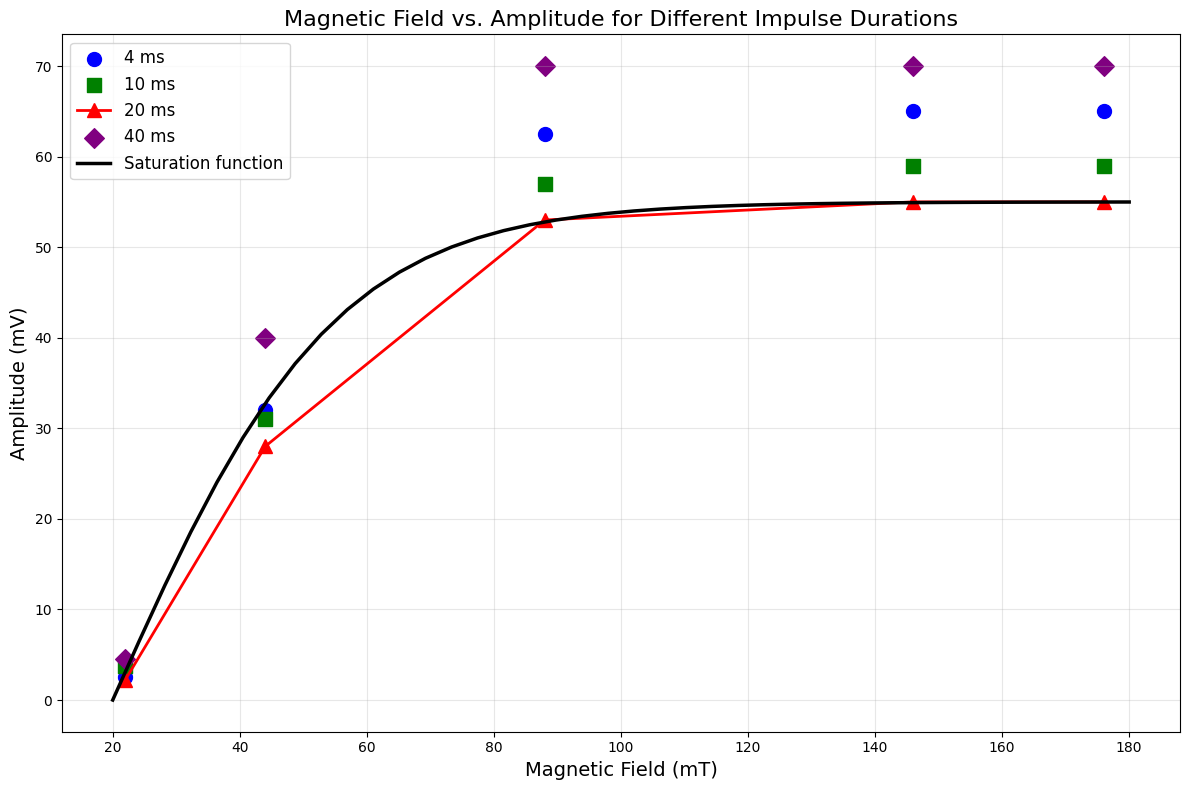

In [5]:
# Data
data = {
    '4 ms': {
        'Amplitude': [22, 44, 88, 146, 176],
        'B': [2.5, 32, 62.5, 65, 65]
    },
    '10 ms': {
        'Amplitude': [22, 44, 88, 146, 176],
        'B': [3.8, 31, 57, 59, 59]
    },
    '20 ms': {
        'Amplitude': [22, 44, 88, 146, 176],
        'B': [2.25, 28, 53, 55, 55]
    },
    '40 ms': {
        'Amplitude': [22, 44, 88, 146, 176],
        'B': [4.5, 40, 70, 70, 70]
    }
}

# Create figure
plt.figure(figsize=(12, 8))

# Plot each impulse duration
markers = ['o', 's', '^', 'D']  # Different markers for each dataset
colors = ['blue', 'green', 'red', 'purple']

for i, (impulse, values) in enumerate(data.items()):
    if impulse == '20 ms':
        # For 20 ms, plot both scatter and lines
        plt.plot(values['Amplitude'], values['B'], 
                marker=markers[i], 
                markersize=10,
                linestyle='-',
                linewidth=2,
                color=colors[i],
                label=impulse)
    else:
        # For others, just scatter
        plt.scatter(values['Amplitude'], values['B'],
                   marker=markers[i],
                   s=100,
                   color=colors[i],
                   label=impulse)

def f_interpolate(field_values):
    # Using np.interp for linear interpolation
    field_magnetic = np.array([0, 22, 44, 88, 146, 176])
    voltage = np.array([0, 2.25, 28, 53, 55, 55])
    return np.interp(field_values, field_magnetic, voltage)


def f(x):
    sat_in = 35
    return 55*np.tanh((x-20)/(sat_in)) 

distance = np.linspace(20, 180, 40)  # More points for smoother curve
saturated_value = f(distance)
# Create plot
# plt.figure(figsize=(15, 7))
plt.plot(distance, saturated_value, label='Saturation function', linewidth=2.5, color='black')


# Add labels and title
plt.xlabel('Magnetic Field (mT)', fontsize=14)
plt.ylabel('Amplitude (mV)', fontsize=14)
plt.title('Magnetic Field vs. Amplitude for Different Impulse Durations', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

### 2 faces Experiment

In [6]:
ex,ey,ez = np.eye(3)
domain={
    'x':np.array([-1.075,1.075])*1e-2,
    'y':np.array([-1.075,1.075])*1e-2,
    'z':np.array([-1.075,1.075])*1e-2
}

parameters ={
    # 'mu':0.03,
    'mu':4e-7*np.pi,
    'e_coils': np.array([1,0,0]),
    'e_direction_sensor':'sensor'
}


#parameters for exponential multicomponents
parameters_mult_exp={
    'A_newt':4.0,
    'A_brow':5.0,
    'remanent':0.5,
    'F_newt':20.0,
    'F_brow':40.0
}
t=0
# psi=exponential_multicomponent(parameters_mult_exp,t)

chi_fe = 25.4
psi = 1*chi_fe

In [7]:
# inner concentration
cotas_2 = {
    'cube':True, 
    'x': np.array([-5.375,0])*1e-3,
    'y': np.array([-5.375,0])*1e-3,
    'z': np.array([-5.375,0])*1e-3
}
num_voxels = 5



mask4,coordinates1,dV_x,nx,ny,nz = domain_mesh_n(domain,cotas_2,nx=num_voxels,ny= num_voxels,nz=num_voxels)
index_coordeinate= np.where(mask4==1)[0][0]
cj_4 = np.zeros(len(coordinates1))
cj_4[mask4]=1*2e-6
true_background=cj_4

In [8]:
sensors_fix= np.array([0,0,-1.075])*1e-2
sensors_fix, sensors_fix+0.015

(array([ 0.     ,  0.     , -0.01075]), array([0.015  , 0.015  , 0.00425]))

In [9]:
grid=grid_volume_n(true_background,domain,nx=num_voxels,ny=num_voxels,nz=num_voxels)
# plot_volume_max_voxels(grid,domain,[sensors_fix],nb=False, num_max_voxels=64)

In [10]:
parameters_coil_device={'num_segments_per_turn':40,
                        'num_turns':20 ,
                        'num_layer_wired':8,
                        # 'axis':'y',
                        'current':1.0
}

num_currents = 50
current_coils = np.linspace(0,100,num_currents)

In [11]:
def f(x):
    sat_in = 35
    return 25*55*np.tanh((x-20)/(sat_in)) # we multiply by the scale factor for transform in unit nanotesla 



In [12]:
index_15mm = np.argmin(np.linalg.norm(coordinates1-np.array([0,0,0.00425]),axis=1)) # el punto est'a a  15 mm del sensor
b_a_index_15mm = np.array([0.26001589]) #theorictical sclaing function of ||u_a(15mm)||/max||u_a|| : u_a magnetic field genertaed by 1

In [ ]:
'''Lead field matrix for sensor plate'''
num_currents = 100
current_coils = np.linspace(20,80,num_currents)#/b_a_index_15mm[0]


Global_Parameters_2_y_p = new_dimentions_two_cylinder_coils_DF_v2([sensors_fix], parameters_coil_device, current_coils,parameters,psi,
                                                                  coordinates1,15,None,[ex,ey,-1], True, channel_1=False,  func_saturation = f)
G_global_2_coils_y_p_10 = Global_Parameters_2_y_p.compute_G_devices_saturation()
G_global_2_coils_y_p_10[::2]

array([[ -982549.28446199, -2622398.99830076, -2284022.72789961, ...,
        -2623623.73435261, -2282801.61237268, -1708138.08993188],
       [ -730600.52548355, -2528793.23595175, -2249246.43357112, ...,
        -2530368.18445409, -2248112.63585575, -1694133.04684265],
       [ -478301.9916362 , -2434754.00830202, -2214321.49760303, ...,
        -2436680.58832687, -2213275.47558406, -1680081.54000051],
       ...,
       [14584912.88921664,  6103448.28159099,  1434739.36940112, ...,
         6077944.29979494,  1427220.52674207,  -182774.33320138],
       [14634887.75326208,  6168718.52761742,  1472383.57613647, ...,
         6143160.88528051,  1464792.93564002,  -165970.13882045],
       [14683492.86154955,  6233257.2913233 ,  1509922.82711554, ...,
         6207649.71284087,  1502261.13510978,  -149160.49087292]])

1 from  5
2 from  5
OK 0
3 from  5
OK 41
4 from  5
OK 72
5 from  5
OK 17
5


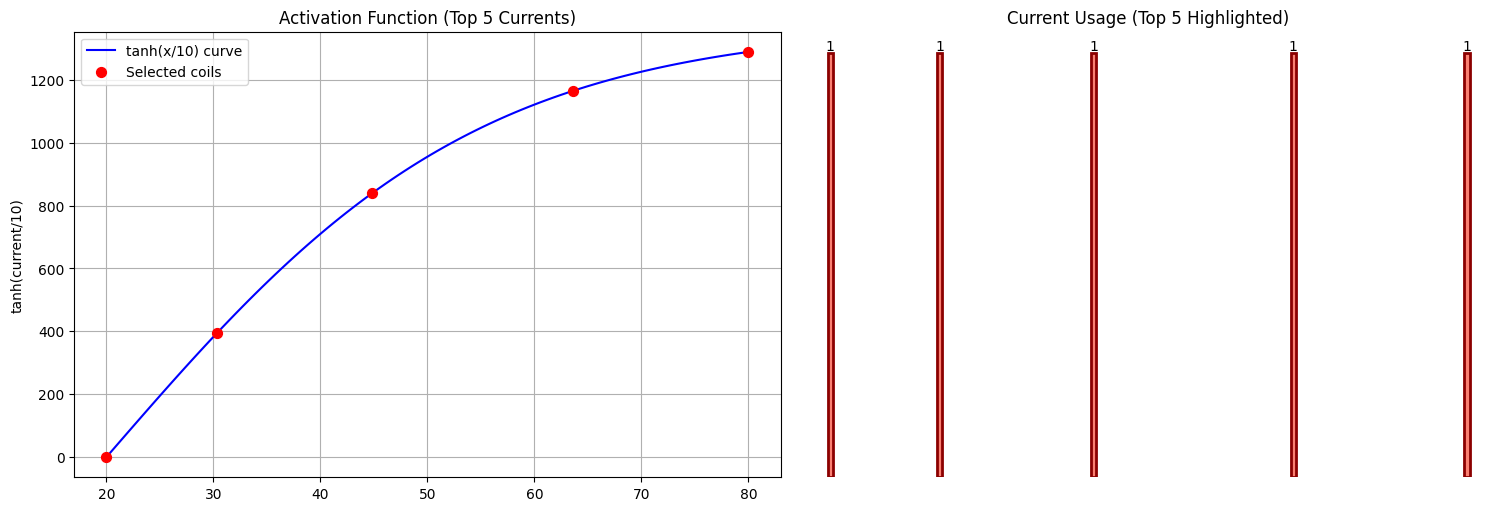

In [30]:
ind_group_global_z,index_counts_global_z = analyze_current_distribution(G_global_2_coils_y_p_10[::2], 1, current_coils , num_currents_list=[5])
create_combined_plots(index_counts_global_z, current_coils, num_currents, [5],f, current_coils)

In [16]:
np.sort(ind_group_global_z)

array([[[ 0, 17, 41, 72, 99]]], dtype=int64)

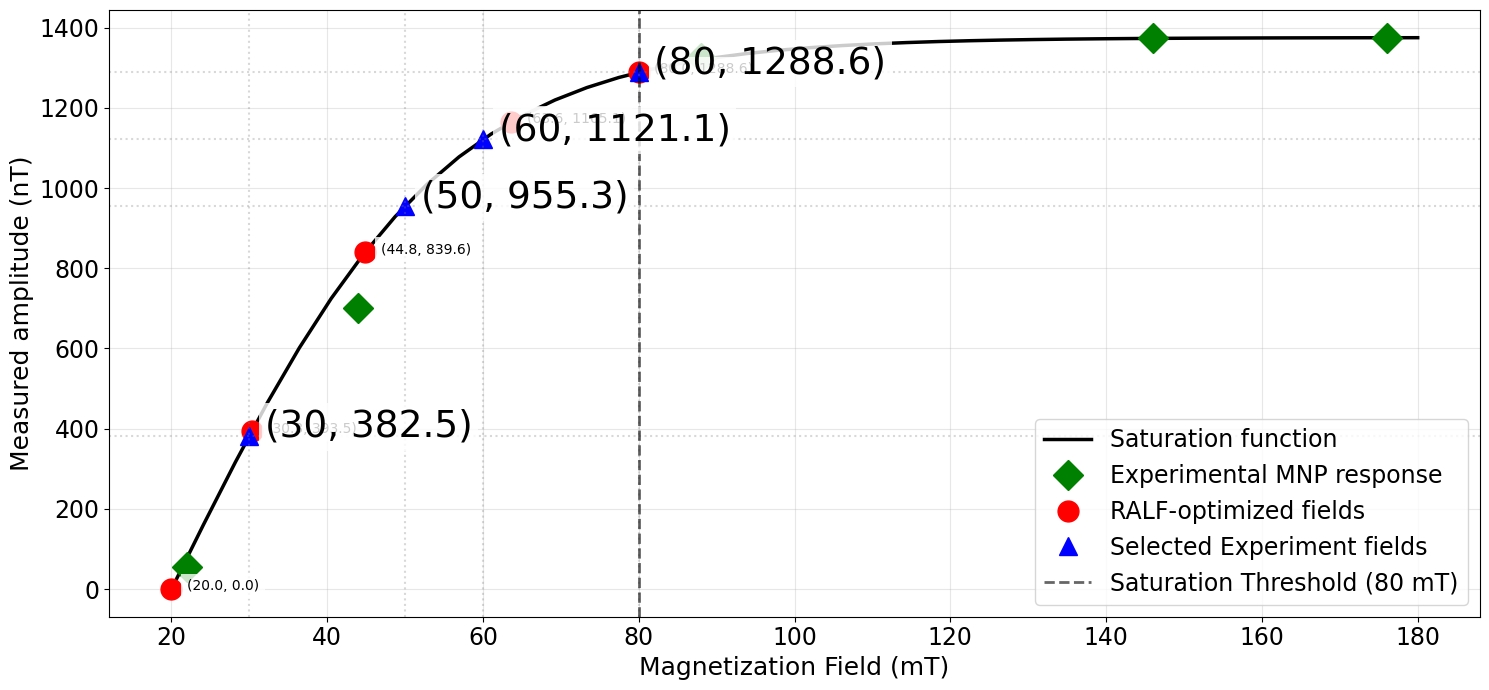

In [21]:
b_a = (Global_Parameters_2_y_p.Dev_x[0].u1_norm/max(Global_Parameters_2_y_p.Dev_x[0].u1_norm))
def f(x):
    sat_in = 35
    return 25*55*np.tanh((x-20)/(sat_in)) #(1 / np.tanh((x-20)/sat_in) - sat_in/(x-20))#


f=f


index_coordenada = index_15mm

# index_coordenada=366# num_currents = 401
# index_coordenada=166 # num_currents = 401
current_coils_aux = current_coils#*b_a_index_15mm[0]#*b_a[index_coordenada]

# ind_group_global_z
# current_coils[ind_group_global_z[1]]


# Generate data
distance = np.linspace(20, 180, 40)  # More points for smoother curve
saturated_value = f(distance)

# Points chosen by RALF Algorithm (using circle markers)
x_markers_ralf = np.sort(current_coils_aux[ind_group_global_z[0]])[0]
target_ys_ralf = [f(x) for x in x_markers_ralf]

# Points chosen for the Experiment (using triangle markers)



x_markers_exp = [30, 50, 60, 80]
target_ys_exp = [f(x) for x in x_markers_exp]

#experiments 
field_magnetic = [22, 44, 88, 146, 176]
voltage = [2.25, 28, 53, 55, 55]

# Create plot
plt.figure(figsize=(15, 7))
plt.plot(distance, saturated_value, label='Saturation function', linewidth=2.5, color='black')
for y, x in zip(voltage, field_magnetic):
    plt.plot(x, 25*y, 'D', markersize=15,  color= 'green',label='Experimental MNP response' if x == field_magnetic[0] else "")
# Add RALF Algorithm points with circle markers
for y, x in zip(target_ys_ralf, x_markers_ralf):
    plt.plot(x, y, 'o', markersize=15,  color= 'red', label='RALF-optimized fields' if x == x_markers_ralf[0] else "")
    plt.text(x+2, y-3, f'({x:.1f}, {y:.1f})', fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    # plt.text(x+2, y-3, f'({x:.1f}, {y:.1f})', fontsize=9, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Add Experiment points with triangle markers
for y, x in zip(target_ys_exp, x_markers_exp):
    plt.plot(x, y, '^', markersize=13, color= 'blue',label='Selected Experiment fields' if x == x_markers_exp[0] else "")
    plt.axhline(y=y, color='gray', linestyle=':', alpha=0.3)
    plt.axvline(x=x, color='gray', linestyle=':', alpha=0.3)
    plt.text(x+2, y-3, f'({x}, {y:.1f})', fontsize=27, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
# Add saturation threshold indicator
plt.axvline(x=80, color='black', linestyle='--', alpha=0.6, linewidth=2,
            label='Saturation Threshold (80 mT)')

# Formatting
plt.xlabel('Magnetization Field (mT)', fontsize=18)
plt.ylabel('Measured amplitude (nT)', fontsize=18)
plt.legend(fontsize=17, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
# plt.xlim([0,180])

plt.tight_layout()
plt.savefig('Langevin_function.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


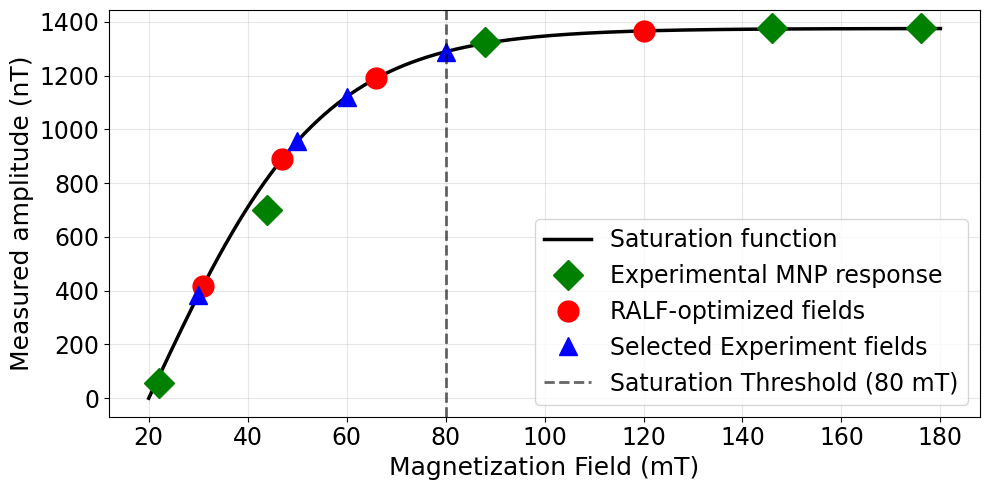